# Importing Libraries

In [ ]:
#from google.colab import files
#uploaded = files.upload()


In [ ]:
import numpy as np, pandas as pd

!pip install talos

import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase

from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos

     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 9.8 MB 9.7 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 5.4 MB 25.2 MB/s 
     |████████████████████████████████| 462 kB 44.8 MB/s 
     |████████████████████████████████| 2.6 MB 35.9 MB/s 
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41608 sha256=967d702f40f62ed74639d3399d3c25069ad80ed566f211a4c5e066cd4ee33517
  Stored in directory: /root/.cache/pip/wheels/f3/2e/7e/316f7da11ccf2195ff05e4a0186a4b5975be9bd0b0004198b6
Successfully built chances
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Importing Data

In [ ]:
train=pd.read_csv('Data/train.csv')

FileNotFoundError: ignored

In [ ]:
train.head(10)

NameError: ignored

In [ ]:
test=pd.read_csv('Data/test.csv')

In [ ]:
test.head(10)

# Data Exploration

Checking for missing values

In [ ]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [ ]:
test.isnull().any()


id              False
comment_text    False
dtype: bool

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

#Data Pre-processing

## Text Normalization

* Removing Characters in between Text
* Removing Repeated Characters
* Converting data to lower-case
* Removing Numbers from the data
* Remove Punctuation
* Remove Whitespaces
* Removing spaces in between words
* Removing "\n"
* Remove Non-english characters

In [ ]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [ ]:
#Ascii Removal step
def asciiremoval(string):
    string = re.sub('[^a-zA-Z.\d\s]', '', string)
    return string

#Removing dates
def remove_dates(sentence):
    for i in range(0,277):
        df1[i] = df1[i].sub('(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s\d{2}\s\d{4}', ' ', sentence)

#Removing Url
def remove_url(txt):
    txt_nourl=re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', txt)
    return txt_nourl

#Punctuation Removal
def removepunct(txt):
    txt_nopunct="".join((c for c in txt if c not in string.punctuation))
    return txt_nopunct

contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}










In [ ]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)
    

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
#Ascii Removal
  text = re.sub('[^a-zA-Z.\d\s]', '', text)
#URL removal
  text=re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)
#Remove all the special characters 
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
#Date Removal 
  text=re.sub('(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s\d{2}\s\d{4}', ' ', text)
  text= re.sub('[^a-zA-Z.\d\s]', '', text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 





Cleaning Training Data

In [ ]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'daww he matches this background colour im seemingly stuck with thanks talk january utc'

Cleaning Test Data

In [ ]:
test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][1048]

'this is a university ip address just fyi '

In [ ]:
train.to_csv('Data/train_preprocessed_first.csv')
test.to_csv('Data/test_preprocessed_first.csv')

In [ ]:
#test=pd.read_csv('Data/train_preprocessed_first.csv')
#train=pd.read_csv('Data/test_preprocessed_first.csv')

## Lemmatization

In [ ]:
comments_train=train['comment_text']
comments_test=test['comment_text']

In [ ]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
#Lemmatization
#Pos Tagging-Noun,verb,adjective,adverb
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text
  
  return str(output.strip()) 

Lemmatizing Training Data

In [ ]:
lemmatized_train_data = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    lemmatized_train_data.append(lemma(line))

In [ ]:
lemmatized_train_data[152458]

'i agree with you about graemels intention he be a revert nazi and wikipedia ha a way of protect against this report him to the wprr threerevertrule notice board post by report the revert nazi graemel ha show himselfherself to be a revert nazi this be unacceptable on a site that be make by it user and not it admins if you feel you have be unjustly revert more than time over a hour period please report himher to the threerevertnoticeboard wprr it be time to take back what be ours'

Lemmatizing Test Data

In [ ]:
lemmatized_test_data = [] 

for line in tqdm_notebook(comments_test, total=len(comments_test)): 
    lemmatized_test_data.append(lemma(line))

## Stopwords Removal

In [ ]:
stopword_list=STOP_WORDS

Adding Single and Dual to STOP_WORDS

In [ ]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [ ]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [ ]:
for letter in dual_alpha_list:
    stopword_list.add(letter)
print("Done!!")

Done!!


Checking for other words that we may need in STOP_WORDS

In [ ]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data

  return str(output.strip())  

In [ ]:
potential_stopwords = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    potential_stopwords.append(search_stopwords(line))

In [ ]:
len(potential_stopwords)

159571

Combining all the sentences in the list into a single string

In [ ]:
def string_combine(stopword):
  final_a=""
  for item in range(1,159571):
    final_a=final_a+" "+stopword[item]
  return final_a



In [ ]:
total_string_potential=string_combine(potential_stopwords)

In [ ]:
print(potential_stopwords)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Counting the number of words in each of the 4 strings

In [ ]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [ ]:
total_string_potential_dict=word_count(total_string_potential)


Converting Dictionaries to Dataframe

In [ ]:
total_string_potential_df = pd.DataFrame(list(total_string_potential_dict.items()),columns = ['Word','Count'])

Getting Dataframe output in descending order

In [ ]:
total_string_potential_df

,Word,Count
0,daww,1
1,match,1062
2,background,770
3,colour,335
4,seemingly,165
...,...,...
195350,nearendless,1
195351,imagebarackobamamother,2
195352,hanumakonda,1
195353,automaker,1


Retaining certain words and removing others from the above list

In [ ]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

Adding above retrived words into the stopwords list

In [ ]:
for word in potential_stopwords:
    stopword_list.add(word)
print("Done!!")

Done!!


Removing Stopwords from Training Data

In [ ]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())      

In [ ]:
processed_train_data = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    processed_train_data.append(remove_stopwords(line))

In [ ]:
processed_train_data[152458]

'agree graemels intention revert nazi protect report wprr threerevertrule notice board post report revert nazi graemel himselfherself revert nazi unacceptable site admins feel unjustly revert hour period report himher threerevertnoticeboard wprr'

Removing Stopwords from Test Data

In [ ]:
processed_test_data = [] 

for line in tqdm_notebook(lemmatized_test_data, total=153164): 
    processed_test_data.append(remove_stopwords(line))

# Model Building

In [ ]:
max_features=100000      
maxpadlen = 200          
val_split = 0.2      
embedding_dim_fasttext = 300

Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)

In [ ]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  195330


Padding

In [ ]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [ ]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  137   562 32684   241   188 32684   241    93    17   559    17   137
   361   562     1  1055   137   329  5354   137   147    17   379   286
   361   562    17     1  1312   137    17   379     2    32   137   562
   188   137   175    45    89   559   137   562    17     2   480   111
    10  1063   420  1066    17  2321   510    36   137    17   188   394
   361     9   252   188   239   146   109    19    20    28   175    77
    20     3   318  4415     5 32684   241   188 32684   241    93   256
   379   300    60   559    37    44    77   422  1495    37   256     8
   559  1281    77  1600   125    10   125  4610   125   101    44   541
  1219    14    77  1327   114   125  1628    77  1097     5   498    77
   455    34   256    60  3222   165  2205   461    34   319  1511    68
   175   233   146  2513    34    34  1517    77  4648  1517    77    34
    77    34   188   256    45    89   559     5    34   256   188    79
    10   833  3087    17    

In [ ]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [ ]:
X_t = X_t[indices]
labels = y[indices]
print('Features are :','\n',X_t)
print('labels are:','\n',labels)

Features are : 
 [[  403  1825     0 ...     0     0     0]
 [  790  1724   115 ...     0     0     0]
 [  232     2    80 ...     0     0     0]
 ...
 [  180 19797   355 ...     0     0     0]
 [   11   109    19 ...     0     0     0]
 [ 3384    97 90533 ...     0     0     0]]
labels are: 
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


### Splitting data into Training and Validation Set

In [ ]:
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]


In [ ]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12243  1267  6775   390  6314  1126]
validation:  [3051  328 1674   88 1563  279]


### Importing Fast Text

In [ ]:
import requests, zipfile, io

zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"

r = requests.get(zip_file_url)

z = zipfile.ZipFile(io.BytesIO(r.content))

z.extractall()


In [ ]:
import codecs
embeddings_index_fasttext = {}

f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')


for line in f:

    values = line.rstrip().rsplit(' ')

    word = values[0]

    coefs = np.asarray(values[1:], dtype='float32')

    embeddings_index_fasttext[word] = coefs

f.close()


In [ ]:
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
        
print("Completed!")
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix_fasttext, axis=1) == 0))

Completed!
number of null word embeddings: 0


### Creating Model

#### Talos Grid Search  for LSTM Model

In [ ]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)
  
  x = GlobalMaxPool1D()(x)
  
  x = Dropout(params['dropout'])(x)
  
  x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [ ]:
p={
    'output_count_lstm': [40,50,60],
    'output_count_dense': [30,40,50],
    'batch_size': [32],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [ ]:
from keras import Sequential
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 323s 75ms/step - loss: 0.0943 - accuracy: 0.7802 - val_loss: 0.0502 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 306s 77ms/step - loss: 0.0507 - accuracy: 0.9772 - val_loss: 0.0482 - val_accuracy: 0.9940


  6%|████▍                                                                           | 1/18 [10:45<3:02:51, 645.41s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 334s 83ms/step - loss: 0.0923 - accuracy: 0.7728 - val_loss: 0.0506 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 331s 83ms/step - loss: 0.0518 - accuracy: 0.9876 - val_loss: 0.0480 - val_accuracy: 0.9939


 11%|████████▉                                                                       | 2/18 [21:52<2:53:49, 651.81s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 363s 91ms/step - loss: 0.0923 - accuracy: 0.8211 - val_loss: 0.0488 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 354s 89ms/step - loss: 0.0500 - accuracy: 0.9867 - val_loss: 0.0475 - val_accuracy: 0.9941


 17%|█████████████▎                                                                  | 3/18 [33:50<2:47:56, 671.73s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 302s 75ms/step - loss: 0.0981 - accuracy: 0.8046 - val_loss: 0.0506 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 303s 76ms/step - loss: 0.0512 - accuracy: 0.9862 - val_loss: 0.0476 - val_accuracy: 0.9940


 22%|█████████████████▊                                                              | 4/18 [43:56<2:32:09, 652.12s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 342s 85ms/step - loss: 0.0884 - accuracy: 0.7862 - val_loss: 0.0499 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 349s 87ms/step - loss: 0.0492 - accuracy: 0.9783 - val_loss: 0.0495 - val_accuracy: 0.9936


 28%|██████████████████████▏                                                         | 5/18 [55:29<2:23:54, 664.23s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 375s 93ms/step - loss: 0.0891 - accuracy: 0.8754 - val_loss: 0.0497 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 369s 92ms/step - loss: 0.0490 - accuracy: 0.9880 - val_loss: 0.0470 - val_accuracy: 0.9922


 33%|██████████████████████████                                                    | 6/18 [1:07:54<2:17:41, 688.44s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 306s 76ms/step - loss: 0.0817 - accuracy: 0.8869 - val_loss: 0.0496 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 304s 76ms/step - loss: 0.0502 - accuracy: 0.9886 - val_loss: 0.0474 - val_accuracy: 0.9941


 39%|██████████████████████████████▎                                               | 7/18 [1:18:05<2:01:57, 665.25s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 343s 86ms/step - loss: 0.0851 - accuracy: 0.8678 - val_loss: 0.0499 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 340s 85ms/step - loss: 0.0503 - accuracy: 0.9873 - val_loss: 0.0474 - val_accuracy: 0.9939


 44%|██████████████████████████████████▋                                           | 8/18 [1:29:29<1:51:49, 671.00s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 380s 95ms/step - loss: 0.0888 - accuracy: 0.8184 - val_loss: 0.0498 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 375s 94ms/step - loss: 0.0495 - accuracy: 0.9863 - val_loss: 0.0472 - val_accuracy: 0.9917


 50%|███████████████████████████████████████                                       | 9/18 [1:42:05<1:44:28, 696.54s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 311s 78ms/step - loss: 0.1060 - accuracy: 0.7205 - val_loss: 0.0519 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 306s 77ms/step - loss: 0.0542 - accuracy: 0.9938 - val_loss: 0.0489 - val_accuracy: 0.9941


 56%|██████████████████████████████████████████▊                                  | 10/18 [1:52:24<1:29:45, 673.16s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 363s 90ms/step - loss: 0.0893 - accuracy: 0.8145 - val_loss: 0.0510 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 355s 89ms/step - loss: 0.0525 - accuracy: 0.9935 - val_loss: 0.0490 - val_accuracy: 0.9941


 61%|███████████████████████████████████████████████                              | 11/18 [2:04:23<1:20:07, 686.82s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 392s 98ms/step - loss: 0.0979 - accuracy: 0.8135 - val_loss: 0.0502 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 385s 96ms/step - loss: 0.0522 - accuracy: 0.9802 - val_loss: 0.0487 - val_accuracy: 0.9941


 67%|███████████████████████████████████████████████████▎                         | 12/18 [2:17:21<1:11:24, 714.15s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 314s 78ms/step - loss: 0.0955 - accuracy: 0.8387 - val_loss: 0.0503 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 309s 78ms/step - loss: 0.0522 - accuracy: 0.9805 - val_loss: 0.0481 - val_accuracy: 0.9939


 72%|█████████████████████████████████████████████████████████                      | 13/18 [2:27:45<57:16, 687.32s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 399s 100ms/step - loss: 0.0982 - accuracy: 0.8164 - val_loss: 0.0510 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 400s 100ms/step - loss: 0.0526 - accuracy: 0.9892 - val_loss: 0.0485 - val_accuracy: 0.9941


 78%|█████████████████████████████████████████████████████████████▍                 | 14/18 [2:41:06<48:05, 721.42s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 415s 104ms/step - loss: 0.0887 - accuracy: 0.8437 - val_loss: 0.0495 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 391s 98ms/step - loss: 0.0516 - accuracy: 0.9872 - val_loss: 0.0491 - val_accuracy: 0.9939


 83%|█████████████████████████████████████████████████████████████████▊             | 15/18 [2:54:34<37:21, 747.20s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 312s 78ms/step - loss: 0.0969 - accuracy: 0.8064 - val_loss: 0.0508 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 296s 74ms/step - loss: 0.0526 - accuracy: 0.9884 - val_loss: 0.0488 - val_accuracy: 0.9941


 89%|██████████████████████████████████████████████████████████████████████▏        | 16/18 [3:04:42<23:31, 705.69s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 359s 89ms/step - loss: 0.0873 - accuracy: 0.8052 - val_loss: 0.0498 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 348s 87ms/step - loss: 0.0509 - accuracy: 0.9726 - val_loss: 0.0484 - val_accuracy: 0.9941


 94%|██████████████████████████████████████████████████████████████████████████▌    | 17/18 [3:16:31<11:46, 706.50s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 373s 93ms/step - loss: 0.0883 - accuracy: 0.7979 - val_loss: 0.0509 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 367s 92ms/step - loss: 0.0515 - accuracy: 0.9831 - val_loss: 0.0475 - val_accuracy: 0.9941


100%|███████████████████████████████████████████████████████████████████████████████| 18/18 [3:28:52<00:00, 696.24s/it]


In [ ]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

6

In [ ]:
analyze_object = talos.Analyze(scan_results)

In [ ]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[0.2, 'sigmoid', 40, 'adam', 30, '05/02/21-021928', 2,
        618.0153393745422, '05/02/21-022946', 32, 2, 'relu', 0],
       [0.1, 'sigmoid', 40, 'adam', 50, '05/02/21-014516', 2,
        610.550302028656, '05/02/21-015526', 32, 2, 'relu', 1],
       [0.2, 'sigmoid', 50, 'adam', 40, '05/02/21-030508', 2,
        800.4046022891998, '05/02/21-031828', 32, 2, 'relu', 2],
       [0.2, 'sigmoid', 60, 'adam', 30, '05/02/21-024145', 2,
        777.378180027008, '05/02/21-025442', 32, 2, 'relu', 3],
       [0.2, 'sigmoid', 50, 'adam', 30, '05/02/21-022946', 2,
        718.1625311374664, '05/02/21-024144', 32, 2, 'relu', 4],
       [0.2, 'sigmoid', 60, 'adam', 50, '05/02/21-035353', 2,
        740.4349722862244, '05/02/21-040613', 32, 2, 'relu', 5],
       [0.1, 'sigmoid', 60, 'adam', 30, '05/02/21-005914', 2,
        717.6658577919006, '05/02/21-011112', 32, 2, 'relu', 6],
       [0.2, 'sigmoid', 40, 'adam', 50, '05/02/21-033156', 2,
        608.267406463623, '05/02/21-034204', 32, 2,

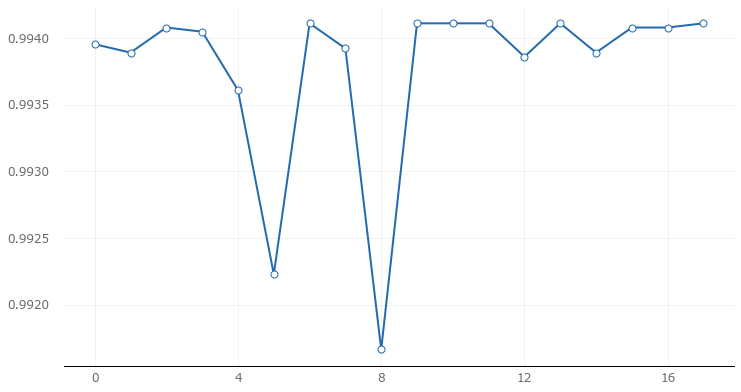

In [ ]:
analyze_object.plot_line('val_accuracy')

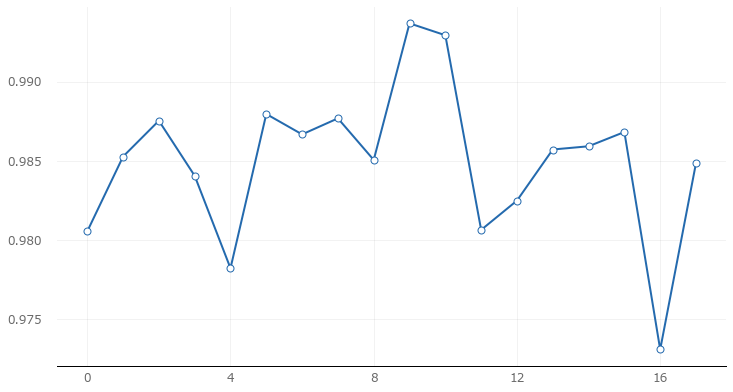

In [ ]:
analyze_object.plot_line('accuracy')

#### Training Model with Best Parameters

LSTM

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [ ]:
x = LSTM(40, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [ ]:
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 300)          58599300  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 40)           54560     
_________________________________________________________________
global_max_pooling1d (Global (None, 40)                0         
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                1230      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0     

In [ ]:
model_info_1=model_1.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 307s 77ms/step - loss: 0.1032 - accuracy: 0.7949 - val_loss: 0.0505 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 305s 77ms/step - loss: 0.0511 - accuracy: 0.9860 - val_loss: 0.0475 - val_accuracy: 0.9941


## Plotting Graphs

### LSTM

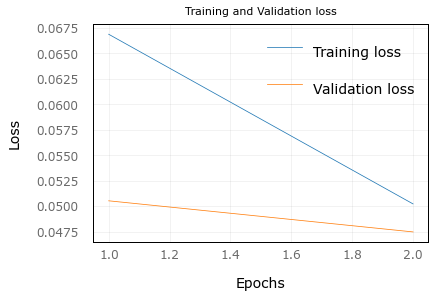

In [ ]:
loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

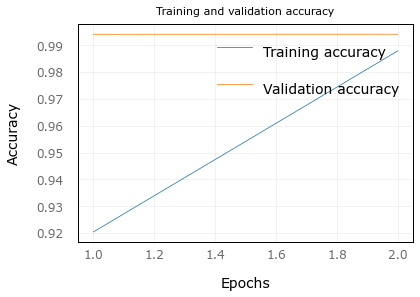

In [ ]:
accuracy = model_info_1.history['accuracy']
val_accuracy = model_info_1.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Saving the Model

In [ ]:
model_1.save('Data/model1')

INFO:tensorflow:Assets written to: Data/model1\assets


INFO:tensorflow:Assets written to: Data/model1\assets


# Loading Saved Model

In [ ]:
loaded_model_1 = keras.models.load_model('Data/model1')

# Generating the Output

### LSTM

In [ ]:
test_values_1 = loaded_model_1.predict([X_te], batch_size=1, verbose=1)

153164/153164 [==============================] - 1106s 7ms/step


In [ ]:
sample_submission = pd.read_csv(r'C:\Users\RD\Toxic-Comment-Classifier-using-Deep-Learning\Data\sample_submission.csv')
test_values_1=pd.DataFrame(test_values_1,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_1],axis=1)
combined_submission.to_csv(r'C:\Users\RD\Toxic-Comment-Classifier-using-Deep-Learning\Data\combined_submission_model_1.csv', index=False)

### LSTM-CNN

# Testing the Created Model

In [ ]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    
    prediction = loaded_model_1.predict(new_string) #(Change to model_1 or model_2 depending on the preference of model type|| Model 1: LSTM, Model 2:LSTM-CNN)
    
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

In [ ]:
toxicity_level('go jump off a bridge jerk')

Toxicity levels for 'go jump off a bridge jerk':
Toxic:         70%
Severe Toxic:  3%
Obscene:       45%
Threat:        2%
Insult:        37%
Identity Hate: 2%



In [ ]:
toxicity_level('i will kill you')

Toxicity levels for 'i will kill you':
Toxic:         56%
Severe Toxic:  6%
Obscene:       11%
Threat:        30%
Insult:        18%
Identity Hate: 13%



In [ ]:
toxicity_level('have a nice day')

Toxicity levels for 'have a nice day':
Toxic:         1%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [ ]:
toxicity_level('fuck ofF!!')

Toxicity levels for 'fuck ofF!!':
Toxic:         99%
Severe Toxic:  33%
Obscene:       97%
Threat:        1%
Insult:        73%
Identity Hate: 1%



In [ ]:
toxicity_level('Hello, How are you?')

Toxicity levels for 'Hello, How are you?':
Toxic:         2%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [ ]:
toxicity_level('get the fuck away from me @sshole!!')

Toxicity levels for 'get the fuck away from me @sshole!!':
Toxic:         99%
Severe Toxic:  33%
Obscene:       96%
Threat:        2%
Insult:        72%
Identity Hate: 1%

